In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('clustering/')

from utils import *

In [34]:
import pandas as pd
import os
cluster_df = pd.read_parquet(os.path.join(get_data_dir(), '2010s', 'cluster_df.parquet'))

data_dir:  /home/lyuzhuoqi/projects/clustering/data


In [35]:
cluster_df

,Scopus_label,movMF_label,movMF_distance,x_val,y_val,kmeans_label,kmeans_distance,skm_label,skm_distance,spectral_label,n2v_kmeans_label,cm_kmeans_label
VID,,,,,,,,,,,,
202381698,Multidisciplinary,22,0.445886,-67.928200,15.572327,17,0.628846,20,0.444711,24,3,21
137773608,Multidisciplinary,22,0.590942,-68.405334,-55.633186,17,0.735654,20,0.559494,24,20,21
125754415,Multidisciplinary,22,0.574571,-68.448853,-55.613579,17,0.705024,20,0.550081,24,20,21
3880285,Multidisciplinary,23,0.618842,-68.407288,-55.634430,8,0.724859,17,0.610582,24,20,21
111155417,Chemistry,23,0.220853,-54.506985,-61.217068,11,0.495787,12,0.198758,14,4,24
...,...,...,...,...,...,...,...,...,...,...,...,...
2764485818,Medicine,21,0.268070,-28.969574,34.819569,18,0.542531,14,0.251015,8,18,1
83454320,Arts and Humanities,25,0.034777,78.609909,31.736822,13,0.251599,3,0.056642,21,5,1
16507453,Arts and Humanities,6,0.113656,89.206772,17.625090,13,0.307089,3,0.128660,21,5,1


In [22]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment
import numpy as np

def match_labels_by_centroids(labels1, labels2, data):
    """
    使用聚类质心的余弦相似度匹配两组标签
    :param labels1: 第一组聚类标签
    :param labels2: 第二组聚类标签
    :param data: 样本数据，用于计算聚类中心
    """
    unique_labels1 = np.unique(labels1)
    unique_labels2 = np.unique(labels2)
    print(len(unique_labels1), len(unique_labels2))

    centroids1 = []
    centroids2 = []

    # 计算每个聚类的质心
    for label in unique_labels1:
        centroids1.append(data[labels1 == label].mean(axis=0))
    for label in unique_labels2:
        centroids2.append(data[labels2 == label].mean(axis=0))

    # 计算余弦相似度
    similarity_matrix = cosine_similarity(centroids1, centroids2)

    # 使用匈牙利算法匹配
    row_ind, col_ind = linear_sum_assignment(-similarity_matrix)  # 负号用于最大化匹配

    # 返回匹配关系
    mapping = {unique_labels1[row]: unique_labels2[col] for row, col in zip(row_ind, col_ind)}
    return mapping, similarity_matrix

data_dir:  /home/lyuzhuoqi/projects/clustering/data
cm_kmeans_label
26 26
{0: 'Computer Science', 1: 'Arts and Humanities', 2: 'Mathematics', 3: 'Pharmacology, Toxicology and Pharmaceutics', 4: 'Agricultural and Biological Sciences', 5: 'Nursing', 6: 'Chemical Engineering', 7: 'Neuroscience', 8: 'Environmental Science', 9: 'Earth and Planetary Sciences', 10: 'Health Professions', 11: 'Social Sciences', 12: 'Decision Sciences', 13: 'Materials Science', 14: 'Physics and Astronomy', 15: 'Dentistry', 16: 'Economics, Econometrics and Finance', 17: 'Engineering', 18: 'Medicine', 19: 'Energy', 20: 'Veterinary', 21: 'Biochemistry, Genetics and Molecular Biology', 22: 'Immunology and Microbiology', 23: 'Business, Management and Accounting', 24: 'Chemistry', 25: 'Psychology'}
{0: '#FF5C29', 1: '#375623', 2: '#FBFF57', 3: '#85D6FF', 4: '#000099', 5: '#9900CC', 6: '#6C0000', 7: '#0099FF', 8: '#D26B04', 9: '#FE0000', 10: '#CCB3FF', 11: '#66FF66', 12: '#16A90F', 13: '#FC9320', 14: '#FFCC00', 15: '#A

(0.0, 1.0, 0.0, 1.0)

<Figure size 640x480 with 0 Axes>

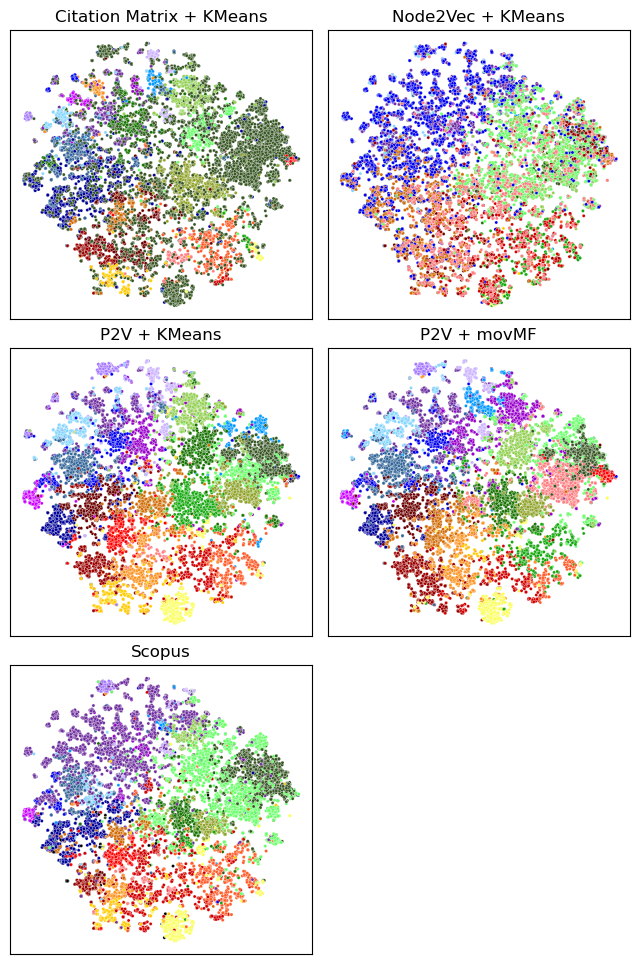

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import KeyedVectors

fig = plt.figure(layout='constrained')
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
plt.subplots_adjust(wspace=0.05, hspace=0.1)
axes = axes.flatten()

wv = KeyedVectors.load(os.path.join(get_data_dir(), '2010s', 'wv'))
all_vectors = wv.get_normed_vectors()
all_VIDs = wv.index_to_key
valid_VIDs = cluster_df[cluster_df['Scopus_label']!='Multidisciplinary'].index.values
valid_vectors = all_vectors[[all_VIDs.index(VID) for VID in valid_VIDs]]

title_dict = {'cm_kmeans_label': 'Citation Matrix + KMeans',
              'n2v_kmeans_label': 'Node2Vec + KMeans',
              'kmeans_label': 'P2V + KMeans',
              'movMF_label': 'P2V + movMF',
              'Scopus_label': 'Scopus'
             }

for i, label in enumerate(['cm_kmeans_label',
                           'n2v_kmeans_label',
                           'kmeans_label',
                           'movMF_label', 
                           'Scopus_label'
                           ]):
        print(label)
        ax = axes[i]
        
        if label != 'Scopus_label':
                cluster2scopus,  similarity_matrix = match_labels_by_centroids(cluster_df[cluster_df['Scopus_label']!='Multidisciplinary'][label], 
                                                                               cluster_df[cluster_df['Scopus_label']!='Multidisciplinary']['Scopus_label'], 
                                                                               valid_vectors)
                print(cluster2scopus)
                cluster2color = {k: Scopus2color[v] for k, v in cluster2scopus.items() if v in Scopus2color}
                print(cluster2color)
                for cluster_label in cluster_df[label].unique():
                        if cluster_label not in cluster2color:
                                cluster2color[cluster_label] = '#000000'

                scatter = sns.scatterplot(data=cluster_df, x='x_val', y='y_val', 
                                        hue=label, palette=cluster2color, s=5,
                                        ax=ax)
        if label == 'Scopus_label':
                scatter = sns.scatterplot(data=cluster_df, x='x_val', y='y_val', 
                                          hue=label, palette=Scopus2color, s=5, 
                                          ax=ax)
        ax.legend().set_visible(False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title_dict[label])
axes[-1].axis('off')